In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import seaborn as sns
sns.set(style='whitegrid')


In [2]:
ehr_age_trajectory_path = ''
save_path = ''
ehr_age = pd.read_csv(ehr_age_trajectory_path)
ehr_age_followup = pd.read_csv('data/followup_status_by_age.csv')
ehr_age = ehr_age.merge(ehr_age_followup, on='patid', how='left')

Index(['patid', '40_age_gap', '45_age_gap', '50_age_gap', '55_age_gap',
       '60_age_gap', '65_age_gap', 'slope', 'gender'],
      dtype='object')
2054608


# Aging acceleration 

In [17]:
import pandas as pd
import numpy as np

def compute_age_gap_transitions(df, age_columns, age_status_col):
    """
    For each column in `age_columns` (e.g. '40_age_gap', '45_age_gap', ...):
      1) compute μ and σ using only patients with status == 1
      2) define bins [-inf, μ-σ, μ, μ+σ, inf]
      3) cut into 4 groups (0–3), assigning pd.NA to patients with status == 0
      4) build pairwise transition matrices between successive ages,
         using only patients valid at both ages.

    Returns:
      df_grp        – original df + grp_{age} columns (with pd.NA)
      transitions   – dict keyed by (age_i, age_j) of crosstab DataFrames
      thresholds    – dict mapping age (str) → list of bin edges
    """
    df_grp = df.copy()
    labels = [0, 1, 2, 3]
    thresholds = {}
    ages = [c.split('_')[0] for c in age_columns]

    # 1) Compute thresholds & label for each age column
    for i in range(len(age_columns)):
        col = age_columns[i]
        status_col = age_status_col[i]
        age = ages[i]
        grp_col_name = f'grp_{age}'

        # --- MODIFICATION 1: Filter for stats calculation ---
        # Use status col to filter for valid patients to calculate stats
        valid_patients_at_age = df_grp[status_col] == 1
        df_valid = df_grp[valid_patients_at_age]

        # Calculate stats only on valid patients
        μ = df_valid[col].mean()
        σ = df_valid[col].std(ddof=1)

        # Define the 5 bin edges
        bins = [-np.inf, μ - σ, μ, μ + σ, np.inf,]
        thresholds[age] = bins + [len(df_valid)]  # Store thresholds
        # --- MODIFICATION 2: Label only valid patients ---
        # Create the new group column, defaulting to pd.NA
        df_grp[grp_col_name] = pd.NA

        # Apply binning ONLY to the valid patients
        df_grp.loc[valid_patients_at_age, grp_col_name] = pd.cut(
            df_valid[col],  # Use the already-filtered df_valid's column
            bins=bins,
            labels=labels
        )

        # Convert to a nullable integer type to hold 0-3 and pd.NA
        df_grp[grp_col_name] = df_grp[grp_col_name].astype('Int64')

    # 2) Build transition matrices between successive ages
    transitions = {}
    for i in range(len(ages) - 1):
        age_i, age_j = ages[i], ages[i+1]
        g0, g1 = f'grp_{age_i}', f'grp_{age_j}'

        # --- MODIFICATION 3: Filter for valid transitions ---
        # Find patients who are valid (not NA) at BOTH time points
        valid_transition = df_grp[g0].notna() & df_grp[g1].notna()
        df_trans = df_grp[valid_transition]

        # Compute crosstab ONLY on this filtered subset
        mat = pd.crosstab(df_trans[g0], df_trans[g1])

        # Ensure all 4 groups are present in the matrix
        mat = mat.reindex(index=labels, columns=labels, fill_value=0)
        transitions[(age_i, age_j)] = mat

    return df_grp, transitions, thresholds

In [28]:
# assume ehr_age is your DataFrame with ['40_age_gap', ..., '65_age_gap'] columns
age_cols = ['40_age_gap','45_age_gap','50_age_gap','55_age_gap','60_age_gap','65_age_gap']
status_cols = ['40_followup_status','45_followup_status','50_followup_status','55_followup_status','60_followup_status','65_followup_status']
# 1. compute
df_with_groups, trans, threshold_df = compute_age_gap_transitions(ehr_age, age_cols, status_cols)
# 1) Build the DataFrame
thres_df = pd.DataFrame.from_dict(threshold_df, 
    orient='index',
    columns=['min', 'Mean-std', 'Mean', 'Mean+std', 'max', 'N'])
# 2) Round to 3 decimal places
thres_df = thres_df.round(3)
thres_df.index = thres_df.index.astype(int)
thres_df.index.name = 'age'
thres_df.to_csv(save_path + '/age_gap_thresholds_updated.csv')

,min,Mean-std,Mean,Mean+std,max,N
40,-inf,-2.634,-1.891,-1.148,inf,2054608
45,-inf,-2.773,-1.921,-1.069,inf,1845257
50,-inf,-2.799,-1.803,-0.806,inf,1631514
55,-inf,-2.888,-1.726,-0.564,inf,1072835
60,-inf,-2.892,-1.526,-0.160,inf,543723
65,-inf,-2.776,-1.273,0.230,inf,219328


In [21]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming 'save_path' is defined elsewhere

def plot_transition_heatmaps_pct(transitions, group_names=None, cmap='Blues', save_path=save_path):

    # 1) Set style
    sns.set(style='whitegrid')

    if group_names is None:
        group_names = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
        
    n = len(transitions)
    # Ensure n_cols is at least 1, even if n=0
    n_cols = max(1, math.ceil(n / 2)) 
    n_rows = 2 if n > 1 else 1 # Use 1 row if only 1 plot
    if n == 0:
        print("No transitions to plot.")
        return

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), sharey=True)
    
    # Ensure axes is always iterable and flat
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten() 

    for ax, ((a0, a1), mat) in zip(axes, transitions.items()):
        
        # --- MODIFICATION HERE ---
        # Convert counts to row percentages, filling NaNs (from 0/0) with 0
        mat_pct = (mat.div(mat.sum(axis=1), axis=0) * 100).fillna(0)
        # --- End Modification ---
        
        mat_pct.index = group_names
        mat_pct.columns = group_names

        # Check if this is the last plot to determine cbar
        is_last_plot = (ax == axes[n-1])

        sns.heatmap(mat_pct, annot=mat_pct.round(1), fmt='.1f',
                    cmap=cmap, cbar=is_last_plot, ax=ax, vmin=0, vmax=100) # Added vmin/vmax
        ax.set_title(f"{a0} → {a1}", fontsize=12, fontweight='bold')
        ax.set_xlabel("To Group", fontsize=10)
        ax.set_ylabel("From Group", fontsize=10)
        ax.set_xticklabels(group_names, rotation=0, fontsize=9)
        ax.set_yticklabels(group_names, rotation=0, fontsize=9)

    # Hide unused axes
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.suptitle("Patient-Group Transition Percentages", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.savefig(save_path + '/age_gap_transitions_heatmap.png', dpi=300)
    plt.show()

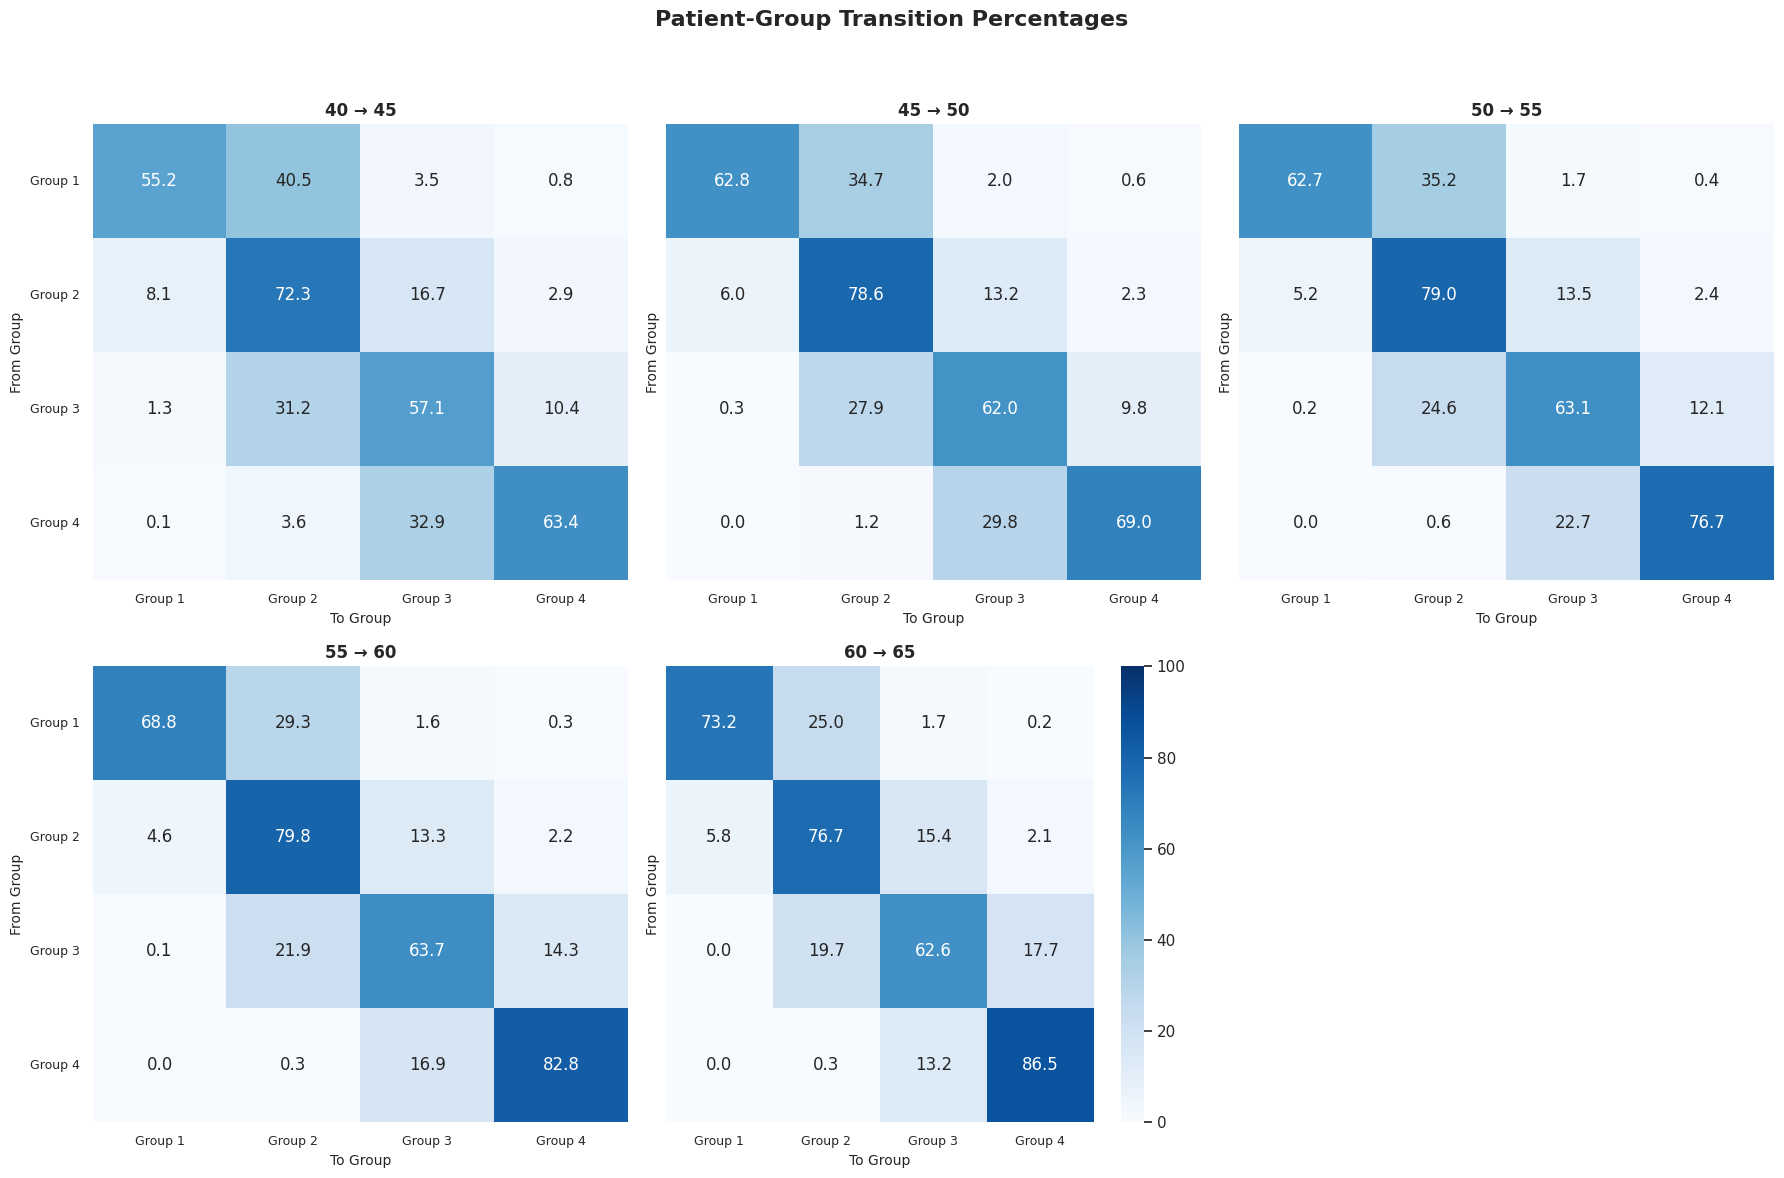

In [22]:
plot_transition_heatmaps_pct(trans)

In [25]:
# 1) Define the two masks for 40→45 transitions
mask_1_to_4 = (df_with_groups['grp_40'] == 0) & (df_with_groups['grp_45'] == 3)
mask_4_to_1 = (df_with_groups['grp_40'] == 3) & (df_with_groups['grp_45'] == 0)
# 2) Subset the DataFrame
trans_1_to_4 = df_with_groups.loc[mask_1_to_4].copy()
trans_4_to_1 = df_with_groups.loc[mask_4_to_1].copy()
# 3) Inspect counts
print(f"40→45: group 1→4  count = {len(trans_1_to_4)}")
print(f"40→45: group 4→1  count = {len(trans_4_to_1)}")

40→45: group 1→4  count = 1877
40→45: group 4→1  count = 255
